In [1]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 599.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install torch-scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 966.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3548505 sha256=36c2baaeed5cfc4e5171a2b6d69549437c3ddd41194dae16d677171ba9be03d0
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter


In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, BatchNorm, global_max_pool
from scipy.spatial import Delaunay
import networkx as nx
from torch_geometric.utils import to_networkx
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

In [4]:
train_df = pd.read_csv("/kaggle/input/landmarkengagement-v3b/TrainEngagement_v3b.csv")
val_df = pd.read_csv("/kaggle/input/landmarkengagement-v3b/ValEngagement_v3b.csv")
test_df = pd.read_csv("/kaggle/input/landmarkengagement-v3b/TestEngagement_v3b.csv")

In [5]:
train_labels = train_df['labels'].values
train_filenames = train_df['file_name'].str.split("_").str[0].values
train_df = train_df.drop(columns=['file_name', 'labels']).values
val_labels = val_df['labels'].values
val_filenames = val_df['file_name'].str.split("_").str[0].values
val_df = val_df.drop(columns=['file_name', 'labels']).values
test_labels = test_df['labels'].values
test_filenames = test_df['file_name'].str.split("_").str[0].values
test_df = test_df.drop(columns=['file_name', 'labels']).values

In [6]:
minmax_scaler = MinMaxScaler()
train_df = minmax_scaler.fit_transform(train_df)
val_df = minmax_scaler.fit_transform(val_df)
test_df = minmax_scaler.transform(test_df)

In [7]:
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [8]:
def create_delaunay_graph_data(X, y):
    num_nodes = X.shape[1] // 2
    data_list = []

    for i in range(X.shape[0]):
        node_features = torch.tensor(X[i].reshape(num_nodes, 2), dtype=torch.float)
        points = node_features.numpy()  # Use x and y for Delaunay triangulation
        tri = Delaunay(points)

        y_tensor = y[i]
        
        edges = set()
        for simplex in tri.simplices:
            for j in range(3):
                for k in range(j + 1, 3):
                    edges.add((simplex[j], simplex[k]))
                    edges.add((simplex[k], simplex[j]))
        
        edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous()
        data_list.append(Data(x=node_features, edge_index=edge_index, y=y_tensor))
    
    return data_list

In [9]:
train_data = create_delaunay_graph_data(train_df, train_labels)
val_data = create_delaunay_graph_data(val_df, val_labels)
test_data = create_delaunay_graph_data(test_df, test_labels)

In [10]:
for i, data in enumerate(train_data):
    data.filename = train_filenames[i]

for i, data in enumerate(val_data):
    data.filename = val_filenames[i]
    
for i, data in enumerate(test_data):
    data.filename = test_filenames[i]

In [11]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [12]:
class SimpleGNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim, num_classes):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 2)
        self.fc1 = torch.nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = global_max_pool(x, batch)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
model = SimpleGNN(num_node_features=2, hidden_dim=32, num_classes=4).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

SimpleGNN(
  (conv1): GCNConv(2, 32)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(32, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=4, bias=True)
)


In [14]:
def train(train_loader):
    model.train()
    video_outputs = {}
    video_labels = {}
    total_loss = 0
    correct = 0

    for data in train_loader:
        data = data.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        loss = loss_fn(outputs, data.y)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        softmax_out = outputs.softmax(dim=1).detach().cpu().numpy()
        labels = data.y.cpu().numpy()

        # Aggregate predictions by video filename
        for filename, pred, label in zip(data.filename, softmax_out, labels):
            if filename not in video_outputs:
                video_outputs[filename] = np.zeros(pred.shape)
                video_labels[filename] = label
            video_outputs[filename] += pred

    # Calculate video-level predictions
    final_preds = []
    final_labels = []

    for filename in video_outputs:
        video_prediction = np.argmax(video_outputs[filename])
        final_preds.append(video_prediction)
        final_labels.append(video_labels[filename])

    train_accuracy = np.sum(np.array(final_preds) == np.array(final_labels)) / len(final_labels)
    train_loss = total_loss / len(train_loader.dataset)
    return train_loss, train_accuracy

In [15]:
def evaluate(val_loader):
    model.eval()
    video_outputs = {}
    video_labels = {}

    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            outputs = model(data)
            val_loss += loss_fn(outputs, data.y).item()

            softmax_out = outputs.softmax(dim=1).detach().cpu().numpy()
            labels = data.y.cpu().numpy()

            # Aggregate predictions by video filename
            for filename, pred, label in zip(data.filename, softmax_out, labels):
                if filename not in video_outputs:
                    video_outputs[filename] = np.zeros(pred.shape)
                    video_labels[filename] = label
                video_outputs[filename] += pred

    # Calculate video-level predictions
    final_preds = []
    final_labels = []

    for filename in video_outputs:
        video_prediction = np.argmax(video_outputs[filename])
        final_preds.append(video_prediction)
        final_labels.append(video_labels[filename])

    val_accuracy = np.sum(np.array(final_preds) == np.array(final_labels)) / len(final_labels)
    val_loss /= len(val_loader.dataset)
    return val_loss, val_accuracy

In [16]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0
best_model_weights = None


for epoch in range(num_epochs):
    train_loss, train_accuracy = train(train_loader)
    val_loss, val_accuracy = evaluate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
print(f"best val acc: {best_val_accuracy}")
torch.save(best_model_weights, 'model_gcn_landmark.pth')

Epoch 1, Train Loss: 0.0253, Train Accuracy: 0.5726, Val Loss: 0.0322, Val Accuracy: 0.5315
Epoch 2, Train Loss: 0.0248, Train Accuracy: 0.6005, Val Loss: 0.0328, Val Accuracy: 0.5357
Epoch 3, Train Loss: 0.0246, Train Accuracy: 0.6113, Val Loss: 0.0327, Val Accuracy: 0.5339
Epoch 4, Train Loss: 0.0245, Train Accuracy: 0.6194, Val Loss: 0.0327, Val Accuracy: 0.5339
Epoch 5, Train Loss: 0.0243, Train Accuracy: 0.6258, Val Loss: 0.0333, Val Accuracy: 0.5333
Epoch 6, Train Loss: 0.0242, Train Accuracy: 0.6295, Val Loss: 0.0332, Val Accuracy: 0.5339
Epoch 7, Train Loss: 0.0242, Train Accuracy: 0.6382, Val Loss: 0.0335, Val Accuracy: 0.5351
Epoch 8, Train Loss: 0.0241, Train Accuracy: 0.6422, Val Loss: 0.0341, Val Accuracy: 0.5256
Epoch 9, Train Loss: 0.0240, Train Accuracy: 0.6441, Val Loss: 0.0341, Val Accuracy: 0.5435
Epoch 10, Train Loss: 0.0240, Train Accuracy: 0.6465, Val Loss: 0.0354, Val Accuracy: 0.5333
best val acc: 0.5434523809523809


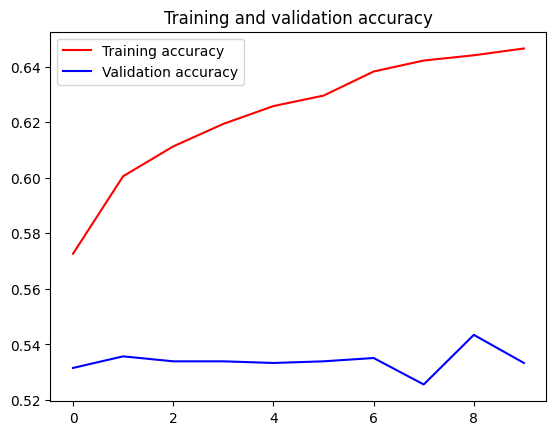

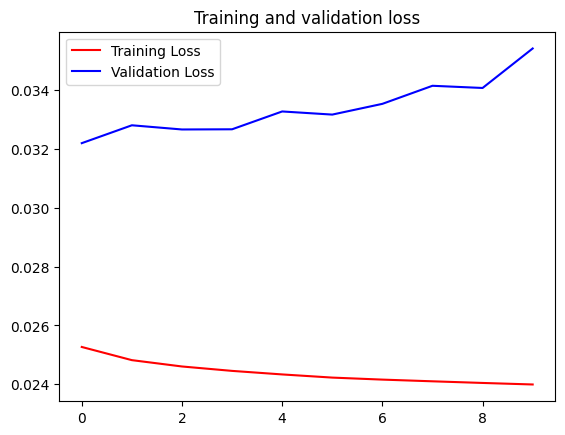

In [17]:
acc = train_accuracies
val_acc = val_accuracies
loss = train_losses
val_loss = val_losses

epochs = range(len(acc))                                                                                                                                                                                                                                                                                                                    

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
model.load_state_dict(torch.load('model_gcn_landmark.pth'))

<All keys matched successfully>

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
def test_model_cnn(test_loader):
    model.eval()
    video_outputs = {}
    video_labels = {}

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)

            out = model(data)
            softmax_out = out.softmax(dim=1).detach().cpu().numpy()
            labels = data.y.cpu().numpy()

            # Aggregate predictions by video filename
            for filename, pred, label in zip(data.filename, softmax_out, labels):
                if filename not in video_outputs:
                    video_outputs[filename] = np.zeros(pred.shape)
                    video_labels[filename] = label
                video_outputs[filename] += pred

    # Calculate video-level predictions
    final_preds = []
    final_labels = []

    for filename in video_outputs:
        video_prediction = np.argmax(video_outputs[filename])
        final_preds.append(video_prediction)
        final_labels.append(video_labels[filename])

    return np.array(final_preds), np.array(final_labels)

# Example usage
test_preds, test_true = test_model_cnn(test_loader)
test_accuracy = np.sum(test_preds == test_true) / len(test_true)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.5056


In [20]:
print("Frame-Level Classification Report (Test):")
print(classification_report(test_true, test_preds, zero_division=0))

Frame-Level Classification Report (Test):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        84
           2       0.51      0.95      0.66       900
           3       0.46      0.06      0.11       796

    accuracy                           0.51      1784
   macro avg       0.24      0.25      0.19      1784
weighted avg       0.46      0.51      0.38      1784



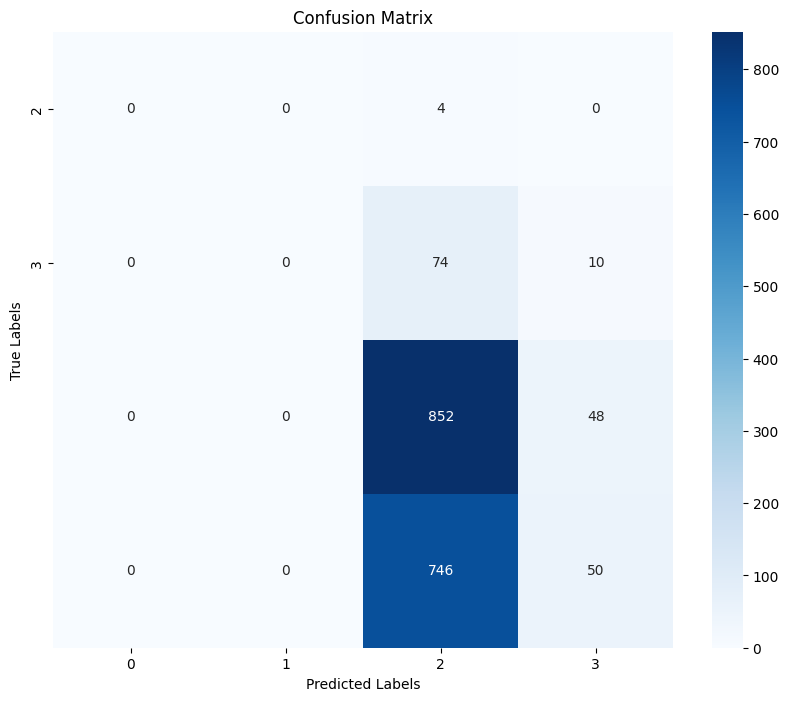

In [21]:
conf_matrix = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_true), yticklabels=np.unique(test_preds))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()